Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import SGD
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

First, we get the data

In [3]:
dataset = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

In [4]:
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [5]:
dataset.shape

(3019, 6)

In [6]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

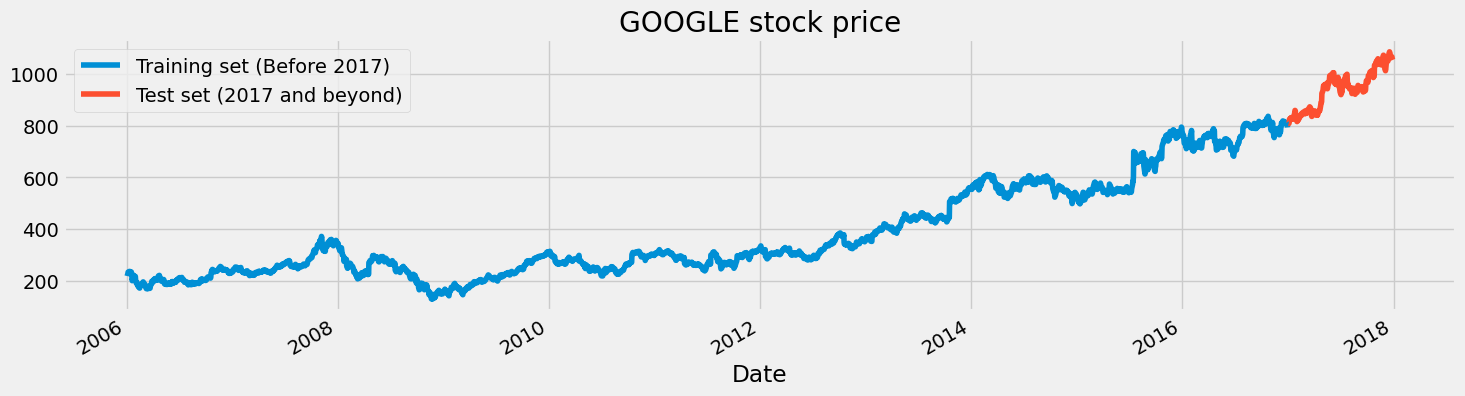

In [7]:
dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('GOOGLE stock price')
plt.show()

Scaling the training set

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

we create a data structure with 60 timesteps and 1 output .So for each element of training set, we have 60 previous training set elements 

In [9]:
timestamp_structure = 60

In [10]:
X_train = []
y_train = []
for i in range(timestamp_structure,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timestamp_structure:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

### LSTM



In [12]:
epochs = 100
batch_size = 32
loss = 'mean_squared_error'
optimizer = 'rmsprop'

In [13]:
regressorLSTM = Sequential()
regressorLSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=50))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(Dense(units=1))
regressorLSTM.compile(optimizer=optimizer,loss=loss)
regressorLSTM.fit(X_train,y_train,epochs=epochs,batch_size=batch_size)

Epoch 1/100
85/85 [==============================] - 11s 58ms/step - loss: 0.0145
Epoch 2/100
85/85 [==============================] - 5s 55ms/step - loss: 0.0064
Epoch 3/100
85/85 [==============================] - 5s 53ms/step - loss: 0.0051
Epoch 4/100
85/85 [==============================] - 5s 54ms/step - loss: 0.0044
Epoch 5/100
85/85 [==============================] - 5s 53ms/step - loss: 0.0037
Epoch 6/100
85/85 [==============================] - 5s 54ms/step - loss: 0.0034
Epoch 7/100
85/85 [==============================] - 5s 58ms/step - loss: 0.0030
Epoch 8/100
85/85 [==============================] - 5s 55ms/step - loss: 0.0032
Epoch 9/100
85/85 [==============================] - 5s 59ms/step - loss: 0.0029
Epoch 10/100
85/85 [==============================] - 5s 54ms/step - loss: 0.0026
Epoch 11/100
85/85 [==============================] - 5s 57ms/step - loss: 0.0025
Epoch 12/100
85/85 [==============================] - 5s 56ms/step - loss: 0.0023
Epoch 13/100
85/85 [====

Now to get the test set ready in a similar way as the training set.

In [14]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - timestamp_structure:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

Preparing X_test and predicting the prices

In [15]:
X_test = []
for i in range(timestamp_structure,len(inputs)):
    X_test.append(inputs[i-timestamp_structure:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)

8/8 [==============================] - 1s 19ms/step


Visualizing the results for LSTM

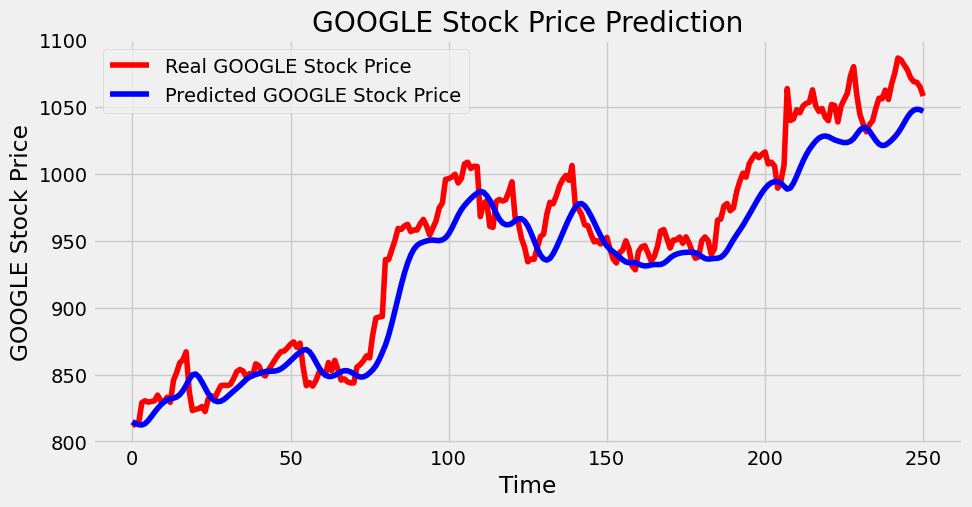

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(test_set, color='red',label='Real GOOGLE Stock Price')
plt.plot(LSTM_predicted_stock_price, color='blue',label='Predicted GOOGLE Stock Price')
plt.title('GOOGLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGLE Stock Price')
plt.legend()
plt.show()

Evaluating our model

In [17]:
rmse = math.sqrt(mean_squared_error(test_set, LSTM_predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 23.958016241264342.


### GRU

In [18]:
epochs = 100
batch_size = 32
loss = 'mean_squared_error'
optimizer = 'rmsprop'

In [19]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer=optimizer,
                     loss=loss)
regressorGRU.fit(X_train,y_train,epochs=epochs, batch_size=batch_size)

Epoch 1/100
85/85 [==============================] - 10s 54ms/step - loss: 0.0115
Epoch 2/100
85/85 [==============================] - 5s 65ms/step - loss: 0.0051
Epoch 3/100
85/85 [==============================] - 5s 64ms/step - loss: 0.0045
Epoch 4/100
85/85 [==============================] - 5s 58ms/step - loss: 0.0039
Epoch 5/100
85/85 [==============================] - 6s 66ms/step - loss: 0.0035
Epoch 6/100
85/85 [==============================] - 5s 64ms/step - loss: 0.0031
Epoch 7/100
85/85 [==============================] - 5s 57ms/step - loss: 0.0029
Epoch 8/100
85/85 [==============================] - 5s 56ms/step - loss: 0.0029
Epoch 9/100
85/85 [==============================] - 5s 57ms/step - loss: 0.0024
Epoch 10/100
85/85 [==============================] - 5s 58ms/step - loss: 0.0025
Epoch 11/100
85/85 [==============================] - 5s 61ms/step - loss: 0.0024
Epoch 12/100
85/85 [==============================] - 5s 62ms/step - loss: 0.0021
Epoch 13/100
85/85 [====

In [20]:
X_test = []
for i in range(timestamp_structure,len(inputs)):
    X_test.append(inputs[i-timestamp_structure:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 1s 15ms/step


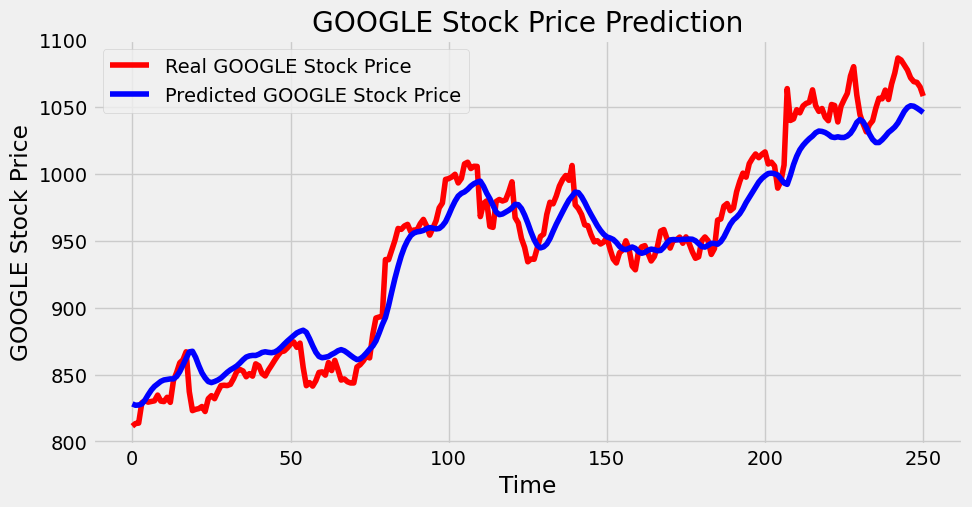

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(test_set, color='red',label='Real GOOGLE Stock Price')
plt.plot(GRU_predicted_stock_price, color='blue',label='Predicted GOOGLE Stock Price')
plt.title('GOOGLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGLE Stock Price')
plt.legend()
plt.show()

In [22]:
rmse = math.sqrt(mean_squared_error(test_set, GRU_predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 18.970193934142355.


### CNN

In [23]:
epochs = 100
batch_size = 32
loss = 'mean_squared_error'
optimizer = 'rmsprop'

In [24]:
regressorCNN = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1)
])
regressorCNN.compile(optimizer=optimizer, loss=loss)
regressorCNN.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 9.7851e-04
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 8.4582e-04
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 8.9381e-04
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 8.4233e-04
Epoch 11/100
85/85 [==============================] - 0s 2ms/step - loss: 7.3135e-04
Epoch 12/100
85/85 [==============================] - 0s 2ms/step - loss: 7.9314e-04
Epoch 13/100


In [25]:
X_test = []
for i in range(timestamp_structure,len(inputs)):
    X_test.append(inputs[i-timestamp_structure:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
CNN_predicted_stock_price = regressorCNN.predict(X_test)
CNN_predicted_stock_price = sc.inverse_transform(CNN_predicted_stock_price)

8/8 [==============================] - 0s 1ms/step


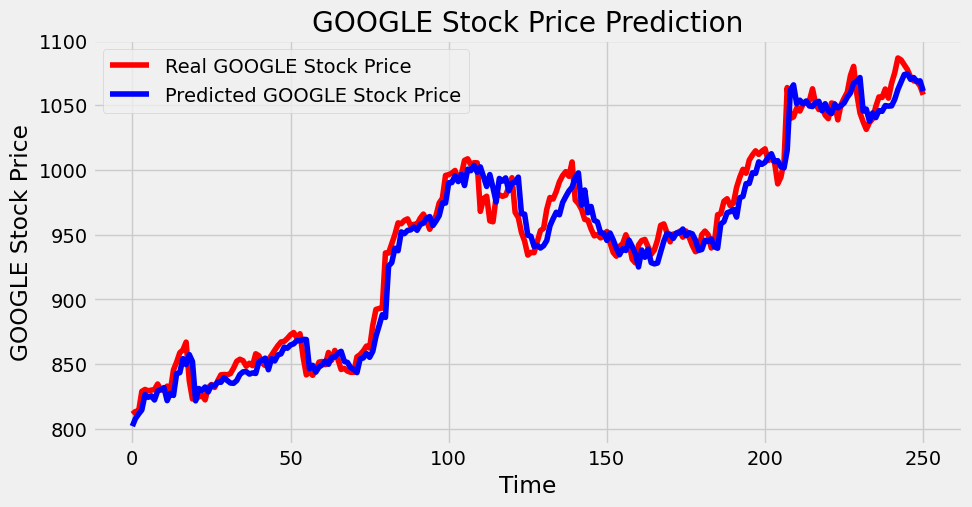

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(test_set, color='red',label='Real GOOGLE Stock Price')
plt.plot(CNN_predicted_stock_price, color='blue',label='Predicted GOOGLE Stock Price')
plt.title('GOOGLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGLE Stock Price')
plt.legend()
plt.show()

In [27]:
rmse = math.sqrt(mean_squared_error(test_set, CNN_predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 12.524086878080398.


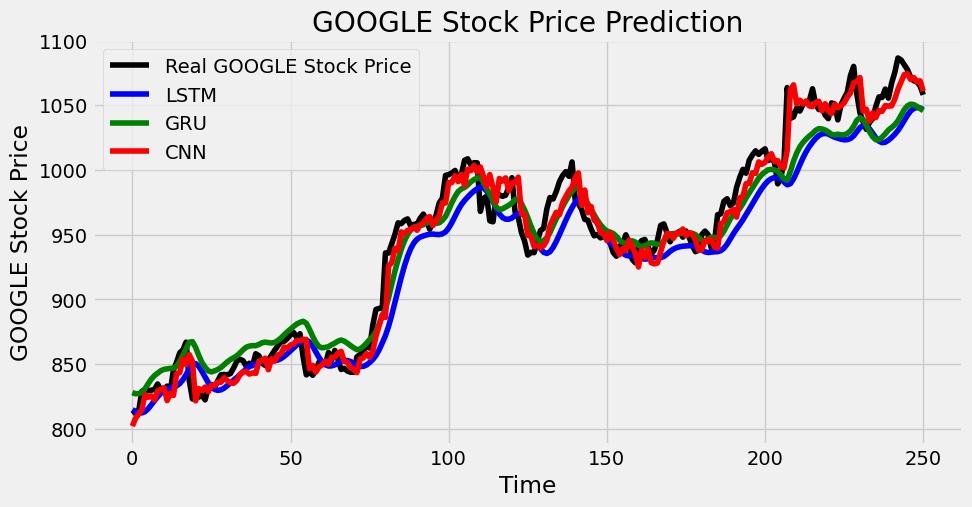

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(test_set, color='black',label='Real GOOGLE Stock Price')
plt.plot(LSTM_predicted_stock_price, color='blue',label='LSTM')
plt.plot(GRU_predicted_stock_price, color='green',label='GRU')
plt.plot(CNN_predicted_stock_price, color='red',label='CNN')
plt.title('GOOGLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGLE Stock Price')
plt.legend()
plt.show()